**Virtual Petri Dish: Spatial simulations and anaylsis of growth, metabolites, and fluxes**


In [2]:
import cobra
import cobra.test # for the e coli core model
import sys
import numpy as np
sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/cometspy")
import cometspy as c
from matplotlib import pyplot as plt


We will use the E. coli core model, which is available in cobrapy.

In [3]:
core = cobra.test.create_test_model("textbook")

We convert the core model into a COMETS model, open its lower exchange bounds (so that they are set by the environment), and set convection parameters to simulate pushing-expansion of the colony. Also, we will pick a number of locations where founder biomass will be deposited.

In [5]:
ecoli = c.model(core)
ecoli.open_exchanges()
ecoli.add_convection_parameters(packedDensity = 0.022,
                                    elasticModulus = 1.e-10,
                                    frictionConstant = 1.0,
                                    convDiffConstant = 0.0)
ecoli.add_noise_variance_parameter(100.)

# ecoli.initial_pop = [[x, x, 1.e-6] for x in [10,20,30,40]]

ecoli.initial_pop = [[140, 50, 1.e-6],
                    [58, 162, 1.e-6],
                    [28,55,1.e-6],
                    [132, 78, 1.e-6],
                    [85, 152, 1.e-6],
                    [73, 123, 1.e-6],
                    [34, 76, 1.e-6],
                    [150, 45, 1.e-6],
                     [120, 73, 1.e-6],
                     [34, 138, 1.e-6],
                     [44, 180, 1.e-6],
                     [180, 150, 1.e-6],
                     [165, 135, 1.e-6],
                     [24, 38, 1.e-6],
                     [44, 45, 1.e-6],
                     [99, 108, 1.e-6],
                     [95, 23, 1.e-6],
                     [35, 101, 1.e-6],
                     [25, 102, 1.e-6]]

Note: for convection parameters to function,
params.all_params['biomassMotionStyle'] = 'Convection 2D'
must also be set


One of the novel aspects of this Protocol is that the "Petri dish" is divided into two different spatial regions, each of which has different metabolite diffusion constants. A user must define a number of parameters to get this to work: the "region map" which is a 2d matrix of integers corresponding to the specific regions, and then the region-specific parameters. We will do these in turn.  

First, the region map.  For this example we will use a simulation arena of 200x200 boxes. Half of the "Petri dish" will be one region, and the second half will be the other region. We will make an integer numpy array that describes this. Here, I will also plot the region map as an image, although this is not at all necessary.

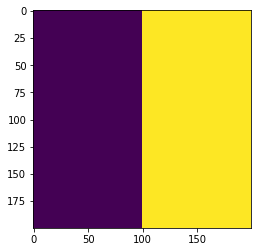

In [6]:
width = 200

grid_size = [width, width] # width boxes in each direction
region_map = np.zeros(grid_size, dtype = int) # an integer array filled with zeros
region_map[:] = 1 # first fill the whole map with 1s
region_map[int(width/2):width,:] = 2 # next fill the bottom half with 2s

# this code here is unnecessary, but useful to visualize your region map:
plt.imshow(np.transpose(region_map))

The region_map looks correct: a square of 200x200 boxes divided into two regions. Let's make the base layout for the simulation and set this region map. Once done, we will set the region parameters.

In [7]:
ly = c.layout([ecoli])
ly.grid = grid_size
ly.set_region_map(region_map)

The region-specific parameters include a metabolite diffusion constant for each metabolite and a single friction constant used for all metabolites, per region. For simplicity we will also use the same metabolite diffusion constant for each metabolite, per region.  This will be 5e-6 (cm2/s) for region 1, and 5e-7 for region 2. The friction constant will be 1.0 for both regions.

Since we are using the same number for each metabolite, we will just make a list that is as long as the number of metabolites in the simulation.

In [8]:
num_mets = ly.media.shape[0]
diffusion_constant_region1 = [5.e-6] * num_mets
diffusion_constant_region2 = [5.e-7] * num_mets
friction_constant = 1.0

We set these values by specifying the (integer) region and then passing the list of diffusion constants and the scalar friction constant.  This must be done separately for each region.

In [9]:
ly.set_region_parameters(1, diffusion_constant_region1, friction_constant)
ly.set_region_parameters(2, diffusion_constant_region2, friction_constant)

The media concentrations will be initially constant across the "Petri dish." We will set these here.

In [10]:
ly.set_specific_metabolite("glc__D_e", 5.e-5)
ly.set_specific_metabolite("h2o_e", 1000.)
ly.set_specific_metabolite("nh4_e", 1000.)
ly.set_specific_metabolite("h_e", 1000.)
ly.set_specific_metabolite("pi_e", 1000.)
ly.display_current_media()

      diff_c g_refresh g_static g_static_val init_amount metabolite
8   0.000005         0        0            0       5e-05   glc__D_e
11  0.000005         0        0            0        1000      h2o_e
12  0.000005         0        0            0        1000        h_e
15  0.000005         0        0            0        1000      nh4_e
17  0.000005         0        0            0        1000       pi_e


We next set the relevant parameters. We must make sure to set 'biomassMotionStyle' to 'Convection 2D' or else biomass will not use the convection parameters set above.

In [11]:
p = c.params()

p.all_params["maxCycles"] = 5000
p.all_params["biomassMotionStyle"] = "Convection 2D"
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = p.all_params["maxCycles"]
p.all_params["defaultKm"] = 0.01
p.all_params["defaultVmax"] = 10
p.all_params["timeStep"] = 0.01
p.all_params["spaceWidth"] = 0.02
p.all_params["maxSpaceBiomass"] = 10
p.all_params["minSpaceBiomass"] = 1.e-10
p.all_params["allowCellOverlap"] = True
p.all_params["writeFluxLog"] = True
p.all_params["FluxLogRate"] = p.all_params["maxCycles"]
p.all_params["writeMediaLog"] = True
p.all_params["MediaLogRate"] = p.all_params["maxCycles"]

Now we make a simulation object and run it.  This can take awhile.

In [12]:
sim = c.comets(ly, p)
# this should all be removable once the installer is made with dependencies in a predictable location
sim.set_classpath("concurrent", "/opt/colt/lib/concurrent.jar")
sim.set_classpath("colt", "/opt/colt/lib/colt.jar")
sim.set_classpath("lang3", "/opt/commons-lang3-3.9/commons-lang3-3.9.jar")
sim.set_classpath("jmatio","/opt/jmatio/lib/jmatio.jar")
sim.set_classpath("math3","/opt/commons-math3-3.6.1/commons-math3-3.6.1.jar")
sim.set_classpath("bin","/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_2.9.2.jar")
sim.set_classpath("gurobi","/opt/gurobi900/linux64/lib/gurobi.jar")
sim.set_classpath("jdistlib", "/opt/jdistlib-0.4.5-bin.jar")

sim.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
gurobi			/opt/gurobi900/linux64/gurobi.jar
junit			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/junit-4.12.jar
hamcrest			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/hamcrest-core-1.3.jar
jogl_all			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives			/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio			/Dropbox/work_related/harcombe_lab/segre/comets

Next, in turn, we use three different helper functions get to biomass, a metabolite concentration, and flux value (growth rate, here) and plot them in 2D space.

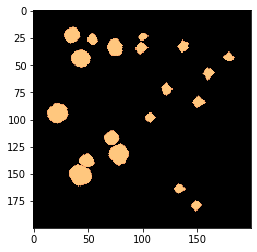

In [41]:
from matplotlib import pyplot as plt
import matplotlib.colors, matplotlib.cm
import copy
my_cmap = matplotlib.cm.get_cmap("copper")
my_cmap.set_bad((0,0,0))
im = sim.get_biomass_image('e_coli_core', p.all_params["maxCycles"])
plt.imshow(im, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)

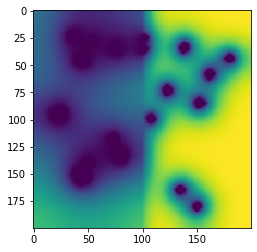

In [42]:
# glucose
plt.imshow(sim.get_metabolite_image("glc__D_e", p.all_params['maxCycles']+1))

In [43]:
# growth rate
im = sim.get_flux_image("e_coli_core", "Biomass_Ecoli_core", p.all_params["maxCycles"])

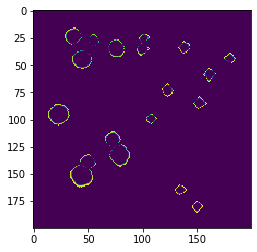

In [44]:
plt.imshow(im)